In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

In [2]:
# Directory path of image and mask dataset
IMAGE_PATH = 'drone/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'drone/dataset/semantic_drone_dataset/label_images_semantic/'

# 23 classes
n_classes = 23 

In [3]:
# Create dataframe of image dataset
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [4]:
# Data preprocessing
def preprocess_data(X, y, size):
    X_processed = []
    y_processed = []
    for i in tqdm(range(len(X))):
        img = cv2.imread(IMAGE_PATH + X[i] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(MASK_PATH + y[i] + '.png', 0)
        img = cv2.resize(img, size)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        X_processed.append(img.reshape(-1, 3))
        y_processed.append(mask.reshape(-1))
    X_processed = np.concatenate(X_processed, axis=0)
    y_processed = np.concatenate(y_processed, axis=0)
    return X_processed, y_processed

df = create_df()
print('Total Images : ', len(df))

Total Images :  400


In [5]:
# Split data into train & test set
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.3, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  238
Val Size     :  42
Test Size    :  120


In [6]:
# define the desired size of the resized images
size = (256, 256)

# Preprocess the data
X_train_processed, y_train_processed = preprocess_data(X_train, X_train, size)
X_val_processed, y_val_processed = preprocess_data(X_val, X_val, size)
X_test_processed, y_test_processed = preprocess_data(X_test, X_test, size)

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
# Check the shape of X_train_processed & y_train_processed
print(X_train_processed.shape)
print(y_train_processed.shape)

(15597568, 3)
(15597568,)


In [8]:
# Predict validation & test accuracy
def getAccuracy(model, X_val_processed):
    # predict on validation set and calculate accuracy
    y_val_pred = model.predict(X_val_processed)
    val_acc = accuracy_score(y_val_processed, y_val_pred)
    print("Validation Accuracy:", val_acc)
    
    # predict on test set and calculate accuracy
    y_test_pred = model.predict(X_test_processed)
    test_acc = accuracy_score(y_test_processed, y_test_pred)
    print("Test Accuracy:", test_acc)

In [9]:
# perform semantic segmentation on one of the images in the dataset
def predictMask(image_id):
    # image_id = '513'
    img = cv2.imread(IMAGE_PATH + image_id + '.jpg')
    # img = cv2.imread("btest2.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(MASK_PATH + image_id + '.png', 0)

    img_resized = cv2.resize(img, size)
    mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

    img_processed = img_resized.reshape(-1, 3)
    
    return img_processed

In [10]:
# Perform cross validation
from sklearn.model_selection import KFold, cross_val_score

def crossValidation(model, X_train_processed, y_train_processed, n_splits):
    # Create a KFold object to split the data into k-folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Compute the cross-validation scores
    cv_scores = cross_val_score(model, X_train_processed, y_train_processed, cv=kf, scoring='r2')

    # Compute the mean and standard deviation of the cross-validation scores
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()

    print("k=",n_splits)
    print("Mean score: ", mean_cv_score)
    print("Standard deviation score: ", std_cv_score)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras import backend as K
import statistics
import seaborn as sns

def evaluateMask(true_mask, predicted_mask): 
    # Flatten the masks to 1D arrays
    true_mask = to_categorical(true_mask.flatten(), num_classes=23)
    predicted_mask = to_categorical(predicted_mask.flatten(), num_classes=23)
    
    # Mean Iou Score
    mean_iou = MeanIoU(num_classes=23)
    mean_iou.update_state(true_mask, predicted_mask)
    iou_score = mean_iou.result().numpy()
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1), labels=range(23))
    
    # Calculate the metrics
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    sns.heatmap(cm, annot=True)

    precision = tp / (tp + fp)
    precision_mean = np.mean(np.nan_to_num(precision))
    recall = tp / (tp + fn)
    recall_mean = np.mean(np.nan_to_num(recall))
    accuracy = np.sum(tp) / np.sum(cm)
    f1_score = 2 * precision * recall / (precision + recall)
    f1_score_mean = np.mean(np.nan_to_num(f1_score))
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient_mean = np.mean(np.nan_to_num(dice_coefficient))
    
    # Print the results
    print("Classification Report:\n", classification_report(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1)))
    print("Mean IoU score:", iou_score)
    print("Recall:", recall_mean)
    print("Precision:", precision_mean)
    print("Accuracy:", accuracy)
    print("F1 score:", f1_score_mean)
    print("Dice coefficient:", dice_coefficient_mean)

    # Plot the confusion matrix
    sns.heatmap(cm, xticklabels=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'
                                 , 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'
                                 , 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 
                                 'P21', 'P22'], 
                yticklabels=['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'
                            , 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'
                            , 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22'],
    annot=True, fmt='d', annot_kws={'fontsize':6}, cmap="YlGnBu")

# Model 1 - Random Forest Classifier

In [12]:
# Train the random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X_train_processed, y_train_processed)

getAccuracy(rf, X_val_processed)

Validation Accuracy: 0.5329891386486235
Test Accuracy: 0.5539922078450521


In [13]:
crossValidation(rf, X_train_processed, y_train_processed, 5)
crossValidation(rf, X_train_processed, y_train_processed, 7)
crossValidation(rf, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.3963524534360532
Standard deviation score:  0.0003778799540746588
k= 7
Mean score:  0.39784320855179406
Standard deviation score:  0.0007954180654731346
k= 9
Mean score:  0.39862245061635065
Standard deviation score:  0.0005117214204303364


In [15]:
image_id = '584'
img = cv2.imread(IMAGE_PATH + image_id + '.jpg')
# img = cv2.imread("btest2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASK_PATH + image_id + '.png', 0)

img_resized = cv2.resize(img, size)
mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

img_processed = img_resized.reshape(-1, 3)

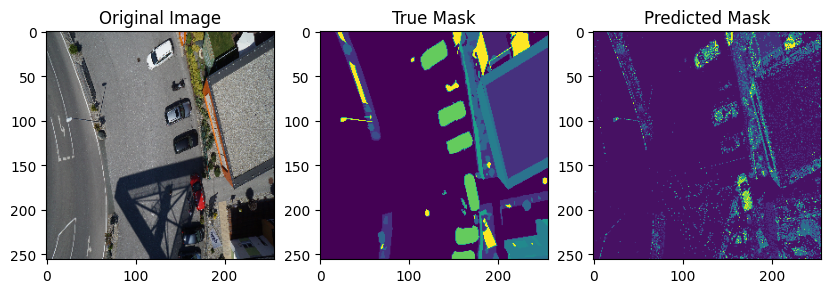

In [15]:
predicted_mask = rf.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.76      0.95      0.84     42609
           2       0.09      0.21      0.13       327
           3       0.15      0.84      0.26       704
           4       0.44      0.05      0.09      9985
           5       0.00      0.04      0.01        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.35      0.34      0.35      1984
           9       0.31      0.34      0.32      1883
          10       0.50      0.14      0.22      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.33      0.03      0.05       690
          14       0.00      0.00      0.00         5
          15       0.01      0.02      0.01        64
          16       0.00      0.00      0.00         5
   

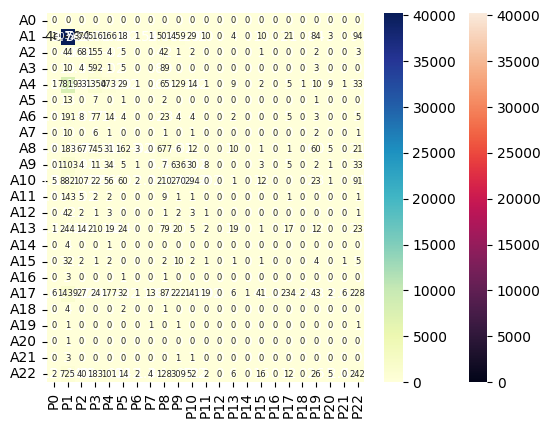

In [16]:
evaluateMask(mask_resized, predicted_mask)

# Model 2 - Decision Tree 

In [17]:
# train the decision tree model
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_processed, y_train_processed)

getAccuracy(dt, X_val_processed)

Validation Accuracy: 0.5317459106445312
Test Accuracy: 0.5555591583251953


In [18]:
crossValidation(dt, X_train_processed, y_train_processed, 5)
crossValidation(dt, X_train_processed, y_train_processed, 7)
crossValidation(dt, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.4036528066573718
Standard deviation score:  0.00024370724684482007
k= 7
Mean score:  0.4049628205423509
Standard deviation score:  0.0008959690120277234
k= 9
Mean score:  0.40565284844926747
Standard deviation score:  0.0006548397934099757


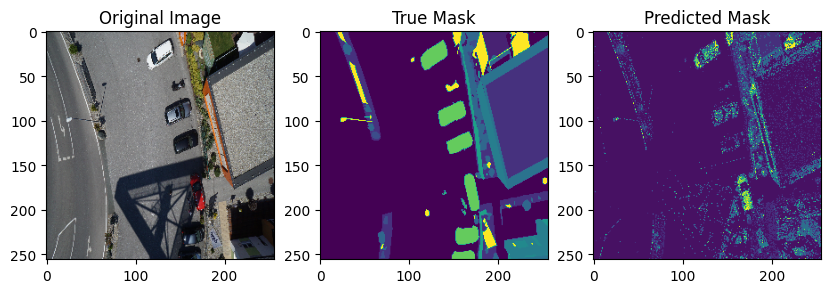

In [19]:
predicted_mask = dt.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.75      0.95      0.84     42609
           2       0.09      0.24      0.13       327
           3       0.15      0.85      0.26       704
           4       0.42      0.04      0.08      9985
           5       0.00      0.04      0.01        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.35      0.31      0.33      1984
           9       0.31      0.33      0.32      1883
          10       0.51      0.13      0.21      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.37      0.03      0.05       690
          14       0.00      0.00      0.00         5
          15       0.01      0.02      0.01        64
          16       0.00      0.00      0.00         5
   

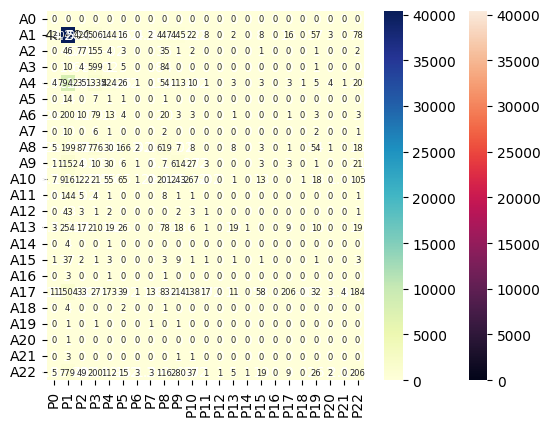

In [20]:
evaluateMask(mask_resized, predicted_mask)

# Model 3 - Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_processed, y_train_processed)

getAccuracy(nb, X_val_processed)

Validation Accuracy: 0.3306764875139509
Test Accuracy: 0.39811719258626305


In [22]:
crossValidation(nb, X_train_processed, y_train_processed, 5)
crossValidation(nb, X_train_processed, y_train_processed, 7)
crossValidation(nb, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.25671519214040606
Standard deviation score:  0.0006004485627815772
k= 7
Mean score:  0.25671037133357166
Standard deviation score:  0.0008074992772973084
k= 9
Mean score:  0.25671908351244443
Standard deviation score:  0.0007407253016998141


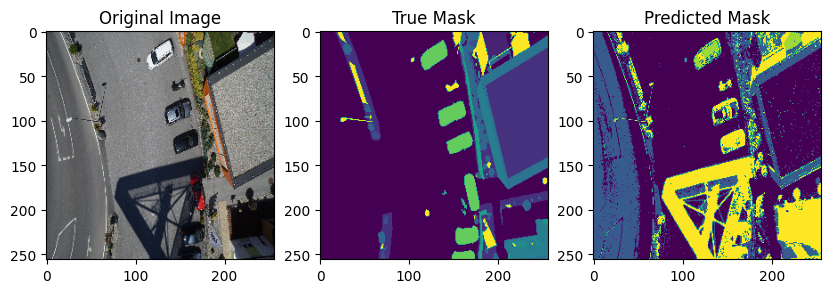

In [23]:
predicted_mask = nb.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.56      0.62     42609
           2       0.00      0.00      0.00       327
           3       0.02      0.54      0.04       704
           4       0.00      0.00      0.00      9985
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.06      0.42      0.11      1984
           9       0.00      0.00      0.00      1883
          10       0.00      0.00      0.00      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00      2751
   

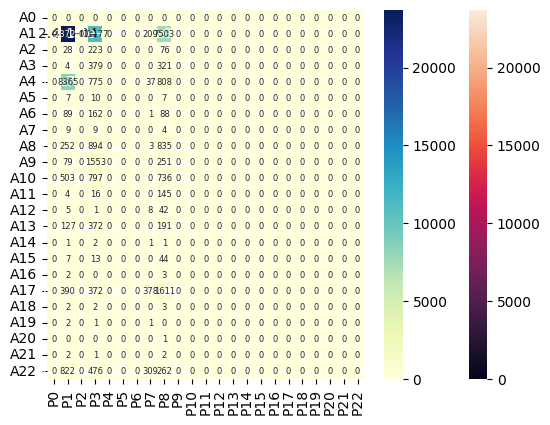

In [24]:
evaluateMask(mask_resized, predicted_mask)

# Model 4 - KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_processed, y_train_processed)

getAccuracy(knn, X_val_processed)

Validation Accuracy: 0.5092032296316964
Test Accuracy: 0.527383550008138


In [26]:
crossValidation(knn, X_train_processed, y_train_processed, 5)
crossValidation(knn, X_train_processed, y_train_processed, 7)
crossValidation(knn, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.36820660852842674
Standard deviation score:  0.001995906483046512
k= 7
Mean score:  0.36801110171488105
Standard deviation score:  0.0015558546131336196
k= 9
Mean score:  0.3670182318810382
Standard deviation score:  0.0012515372200030798


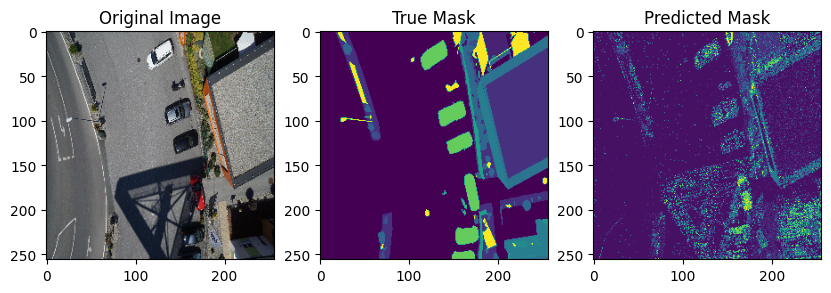

In [27]:
predicted_mask = knn.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8888\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.77      0.89      0.82     42609
           2       0.10      0.22      0.14       327
           3       0.14      0.75      0.23       704
           4       0.37      0.09      0.14      9985
           5       0.00      0.00      0.00        24
           6       0.05      0.01      0.01       340
           7       0.00      0.00      0.00        22
           8       0.41      0.31      0.35      1984
           9       0.27      0.41      0.32      1883
          10       0.43      0.16      0.23      2036
          11       0.01      0.01      0.01       165
          12       0.00      0.00      0.00        56
          13       0.29      0.03      0.05       690
          14       0.00      0.00      0.00         5
          15       0.01      0.05      0.01        64
          16       0.00      0.00      0.00         5
   

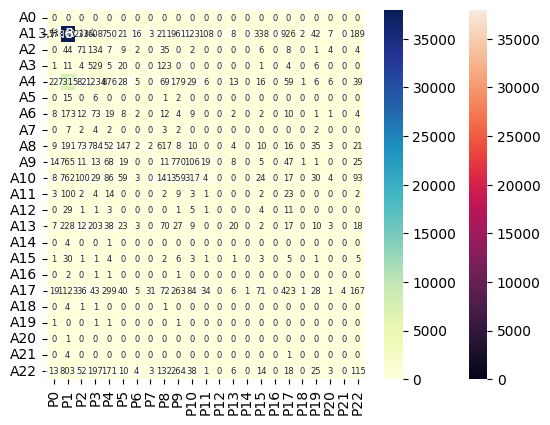

In [28]:
evaluateMask(mask_resized, predicted_mask)

# Model 5 - XGBClassifier

In [12]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=10, tree_method='gpu_hist')
xgbc.fit(X_train_processed, y_train_processed)

getAccuracy(xgbc, X_val_processed)

Validation Accuracy: 0.5109223865327381
Test Accuracy: 0.537670389811198


In [13]:
crossValidation(xgbc, X_train_processed, y_train_processed, 5)
crossValidation(xgbc, X_train_processed, y_train_processed, 7)
crossValidation(xgbc, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  -0.10377526879750602
Standard deviation score:  0.0022725881570254077
k= 7
Mean score:  -0.1047836978219842
Standard deviation score:  0.0024296687920771403
k= 9
Mean score:  -0.10346752729759305
Standard deviation score:  0.0030517326774213


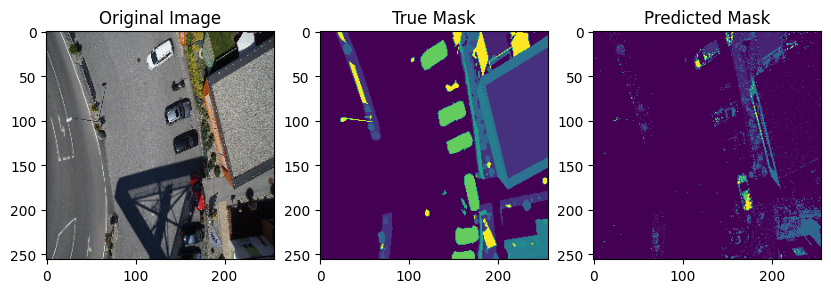

In [16]:
predicted_mask = xgbc.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_5372\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_5372\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_5372\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_5372\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.97      0.82     42609
           2       0.16      0.05      0.07       327
           3       0.18      0.89      0.30       704
           4       0.03      0.00      0.00      9985
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.25      0.31      0.28      1984
           9       0.05      0.02      0.03      1883
          10       0.81      0.10      0.18      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       0.99      0.04      0.07      2751
   

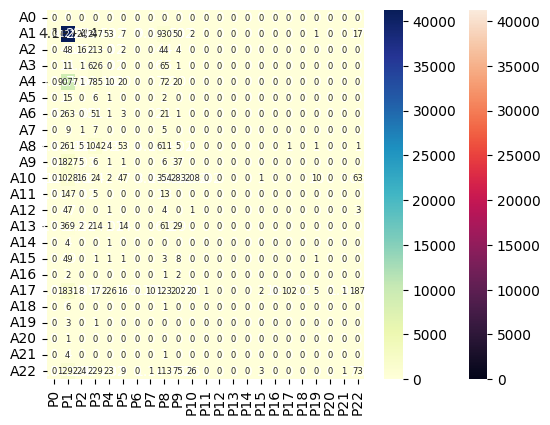

In [17]:
evaluateMask(mask_resized, predicted_mask)

# Conclusion
# Best Model = DeepLab v3+